In [1]:
using Pkg
pkg"activate ."
pkg"instantiate"
pkg"precompile"

  Updating registry at `C:\Users\mwaugh\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Precompiling project...
Precompiling PerlaTonettiWaugh


┌ Info: Recompiling stale cache file C:\Users\mwaugh\.julia\compiled\v1.0\PerlaTonettiWaugh\Zi3ee.ji for PerlaTonettiWaugh [d2cacc76-b06b-11e8-362b-f18d03a16405]
└ @ Base loading.jl:1190


In [2]:
import Pkg; Pkg.add("Plots")
using PerlaTonettiWaugh, Plots, BenchmarkTools

 Resolving package versions...
  Updating `C:\Users\mwaugh\github\PerlaTonettiWaugh.jl\Project.toml`
 [no changes]
  Updating `C:\Users\mwaugh\github\PerlaTonettiWaugh.jl\Manifest.toml`
 [no changes]


In [3]:
gr(fmt = :png)

Plots.GRBackend()

# Steady states

## Solving steady state solutions

Set up parameters and find the corresponding stationary solution:

Below are the results from the **updated** matlab calibration with the corresponding letters. Here I added the $\mu$ parameter in the calibration routine to fit the firm dynamic moments. Fit improved a lot and it generated a negative drift term which is what we need to keep S from going negative.


In [545]:
cal = (d = 4.0671, θ = 3.1522, κ = 0.0130 , χ = 1/3.9762, υ = 0.0867, σ =3.0, ζ = 1.0 , δ = 0.01, μ = -0.0336)

#####################
# Old calibrations maybe to keep track of...
#cal = (d = 2.7943, θ = 4.9412, κ = 0.0088, χ = 1/2.3928, υ = 0.0689, σ = 4.0520)
#cal.θ

#cal = (d = 4.4007 , θ = 3.1879, κ = 0.0076, χ = 1.0/2.0927, υ = 0.1034, σ =3.0, ζ = 1.00)
#cal_0 = merge(cal, (d = 4.93, )) # calibrated parameter for d in SS at t = 0 
#cal

(d = 4.0671, θ = 3.1522, κ = 0.013, χ = 0.2514964036014285, υ = 0.0867, σ = 3.0, ζ = 1.0, δ = 0.01, μ = -0.0336)

Side note on previous version. Essentially, under this calibration, the parameters are very simmilar. Theta, chi, kappa are quite close to what we had in the prior version.

In [542]:
# Define common objects. 
parameters = parameter_defaults()

settings = settings_defaults()
settings = merge(settings, (transition_penalty_coefficient = 1.0, ))
z_grid = settings.z
M = length(z_grid)

d_0 = 1 + (cal.d-1).*1.10 # Here is the 10 percent tariff increase
d_T = cal.d

params_0 = merge(parameters, (d = d_0, θ = cal.θ, κ = cal.κ, χ = cal.χ, υ = cal.υ, σ = cal.σ, ζ = cal.ζ , δ  = cal.δ, μ = cal.μ, )) # parameters to be used at t = 0
params_T = merge(parameters, (d = d_T, θ = cal.θ, κ = cal.κ, χ = cal.χ, υ = cal.υ, σ = cal.σ, ζ = cal.ζ , δ  = cal.δ, μ = cal.μ, )) # parameters to be used at t = T

# initial value
initial_x = [0.02; 2; .57]

# solve for stationary solution at t = 0
stationary_sol_0 = stationary_algebraic(params_0, initial_x) # solution at t = 0
stationary_sol = stationary_algebraic(params_T, initial_x) # solution at t = T

Ω_0 = stationary_sol_0.Ω;
Ω_T = stationary_sol.Ω;

In [543]:
d_0 

4.373810000000001

In [544]:
print(stationary_sol.U_bar(1),'\n') 
print(stationary_sol_0.U_bar(1),'\n')
print(stationary_sol_0.S,'\n')
print(stationary_sol.S,'\n')

74.98440522003126
67.01048204864021
0.12086544156401964
0.13163203932143278


Note that $S$ is now well above zero, not like in the old calibrations. 

## Welfare in steady states

### Steady state at `T`

In [546]:
display_stationary_sol(stationary_sol);

g = 0.020006154454827296
z_hat = 1.668729308898673
Ω = 1.342909737124475
y = 1.6150634231509708
c = 1.6150634231509708
U_bar = getfield(PerlaTonettiWaugh, Symbol("##46#47")){Float64,Float64,Float64,Float64}(0.020006154454827296, 0.02, 1.0, 1.6150634231509708)
λ_ii = 0.7682817261859983
L_tilde = 0.26144392450385456
z_bar = 2.186785102358013
w = 0.728928367452671
x = 1.0
π_min = 0.07722203927683058
r = 0.0500061544548273
a = 8.18474415205518
b = 0.1674011393523267
S = 0.13163203932143278


### Steady state at `0`

In [547]:
display_stationary_sol(stationary_sol_0);

g = 0.016590572398671868
z_hat = 1.8034435410599656
Ω = 1.4346818769179375
y = 1.6390068000265354
c = 1.6390068000265354
U_bar = getfield(PerlaTonettiWaugh, Symbol("##46#47")){Float64,Float64,Float64,Float64}(0.016590572398671868, 0.02, 1.0, 1.6390068000265354)
λ_ii = 0.8074451885316565
L_tilde = 0.25661031986988847
z_bar = 2.204774755199277
w = 0.7349249183997589
x = 1.0
π_min = 0.0764641873307379
r = 0.04659057239867187
a = 8.669465503238168
b = 0.17637881073197922
S = 0.12086544156401964


### Outstanding Issue \#1: Sensetivity of growth to trade.

This is a big difference relative to previous version. As noted above, with parameters values that are quite simmilar to what we had before, the growth rate is changing a lot with only a very small change in trade flows. Why?

---

# Transition dynamics

Setup for optimizer:

In [549]:
settings = merge(settings, (params_T = params_T, stationary_sol_T = stationary_numerical(params_T, z_grid), Ω_0 = Ω_0, transition_iterations = 0, T = 75.0));

Use the solution found with calibrated parameters above for `E`

In [550]:
settings = merge(settings, (transition_x0 = [-0.91839, -0.797426, -0.61209, -0.500276, -0.319928, -0.235112, -0.235112, -0.121364, -0.100241, -0.0801344, -0.049003, -0.040901, -0.040901, -0.0178076], ));

Find the corresponding solution

In [551]:
@time result = solve_full_model(settings; impose_E_monotonicity_constraints = true)
solved = result.solution;
E_nodes = result.E_nodes;

solved = solved.results;

  1.153550 seconds (3.07 M allocations: 1.781 GiB, 17.40% gc time)


---
## Welfare Gains

In [552]:
print("Utility in initial SS: ", stationary_sol_0.U_bar(1),"\n")
print("Utility in new SS: ", stationary_sol.U_bar(1),"\n")

Utility in initial SS: 67.01048204864021
Utility in new SS: 74.98440522003126


In [553]:
print("Utility immidetly after change ", solved.U[1],"\n")

Utility immidetly after change 89.41361799248745


#### Summary so far...

In the old paper, what we did was take U_0_ss at some date t, then compare it to U_ss at the same date t. This is like an instentanous jump to the new ss. This is what the first cell is looking at and note that this is like a 17 percent increase in utility. Higher than what we had in the paper, but in of the same order of magnitude. 

The next cell reprots the utility just after the change. Utility here includes the future path of consumption and change in growth rate, so it "bakes in" the transition path. Here it goes up by much more than utility in the new SS. This is what I was expecting given the dynamics of consumption. 

Just a reminder about how the function `counsumption_equivalent(U_new, U_old, parameters)` works, it takes U_new and then U_old in that order, then evaluates the **gross** increase in consumption. 100 times this value **minus one** gives the permanent, percent increase in consumption required to make the agent indifferent between the two paths. 

In [554]:
T = solved.t[end]
lambda_ss = 100*(consumption_equivalent(stationary_sol.U_bar(0), stationary_sol_0.U_bar(0), parameters)-1)

print("SS to SS welfare gain: ", lambda_ss,"\n")

SS to SS welfare gain: 16.88997027956154


In [525]:
lambda_tpath = 100*(consumption_equivalent(solved.U[1], stationary_sol_0.U_bar(0), parameters)-1)

print("Inclusive of the Transition Path: ", lambda_tpath,"\n")

Inclusive of the Transition Path: 59.14623193529911


### Relative to initial notebook computations

- SS to SS, the issue here is that we should compare **at date 0** utility in the first ss vs. the second ss. This is what we must have been doing in the previous version of the paper. The previous calulation in the old notebook had 
```consumption_equivalent(solved.U[end], stationary_sol_0.U_bar(T), parameters)```
which took **date T** utility and compard them. The problem is that this now depends on date T. So if we picked T to be arbitraily large, then utility will be arbitraily different.

- Following the same logic, the transition path should compare **date 0** utility with the initial value from the transition path. So what we want to do is to compare everything at 0. In the previous calculation, we had
```consumption_equivalent(solved.U[1], stationary_sol_0.U_bar(T), parameters)```
were comparing the initial utility relative to ss utility on the old path at date T. So the initial blue point below versues the last orange dashed point. **See the figure below**

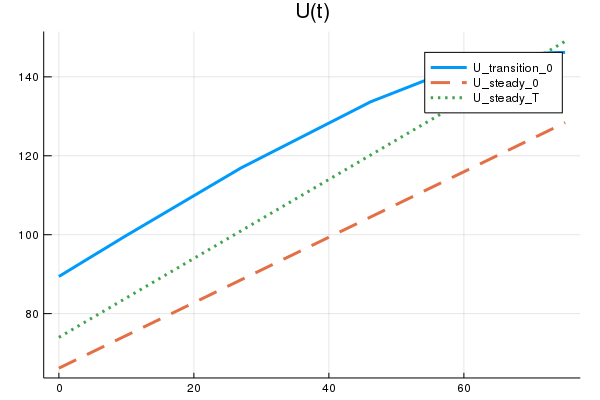

In [526]:
plot(solved.t, 
    [solved.U, stationary_sol_0.U_bar, stationary_sol.U_bar], 
    label = ["U_transition_0", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

### Outstanding Issue \#2: Welfare Gains still depend on T in transition path.

The stuff above I think is correct, the one issue is why does the welfare gains, inclusive of the transition path seem to depend on T??? So change T above from 40 to 75 or 100, then the welfare gains fall alot? Why?

---
## Ploting and other checks

In [527]:
solved.U[end]

146.18754910506343

In [528]:
println("E_nodes (sorted) : ")
sort(E_nodes)

E_nodes (sorted) : 


14-element Array{Float64,1}:
 -0.91839  
 -0.797426 
 -0.61209  
 -0.500276 
 -0.319928 
 -0.235112 
 -0.235112 
 -0.121364 
 -0.100241 
 -0.0801344
 -0.049003 
 -0.040901 
 -0.040901 
 -0.0178076

In [529]:
@show E_nodes

E_nodes = [-0.91839, -0.797426, -0.61209, -0.500276, -0.319928, -0.235112, -0.235112, -0.121364, -0.100241, -0.0801344, -0.049003, -0.040901, -0.040901, -0.0178076]


14-element Array{Float64,1}:
 -0.91839  
 -0.797426 
 -0.61209  
 -0.500276 
 -0.319928 
 -0.235112 
 -0.235112 
 -0.121364 
 -0.100241 
 -0.0801344
 -0.049003 
 -0.040901 
 -0.040901 
 -0.0178076

## Plots for Ω and residuals

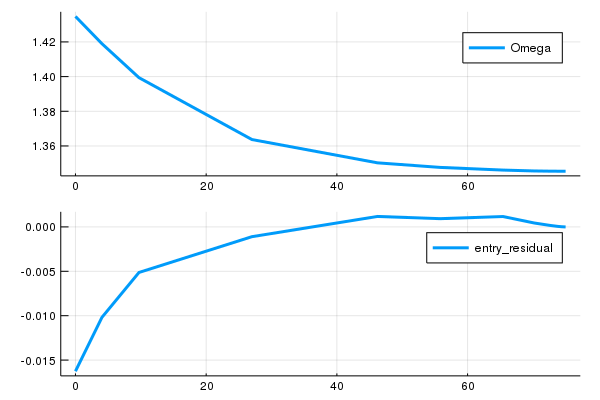

In [530]:
#solved = solved.results;
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

## Primary Plots

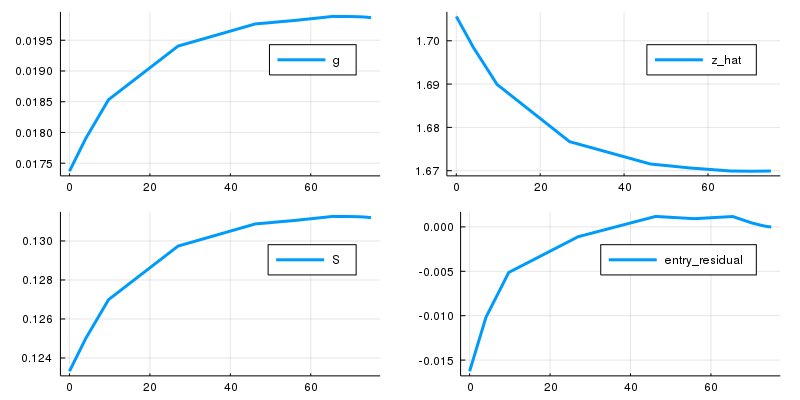

In [531]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2), size = (800, 400))

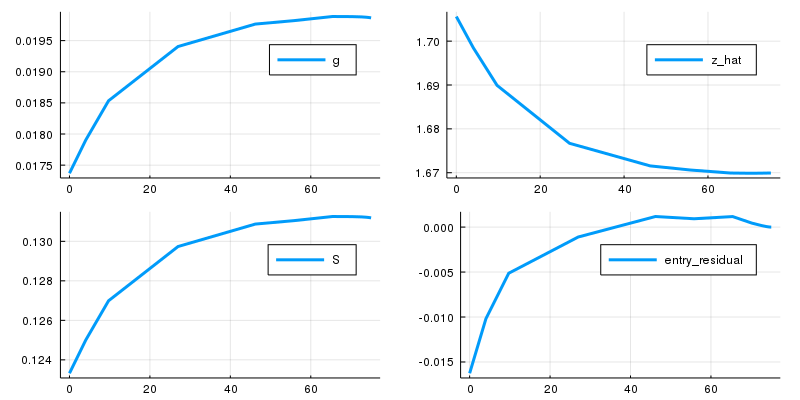

In [532]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2), size = (800, 400))

## Static Equations

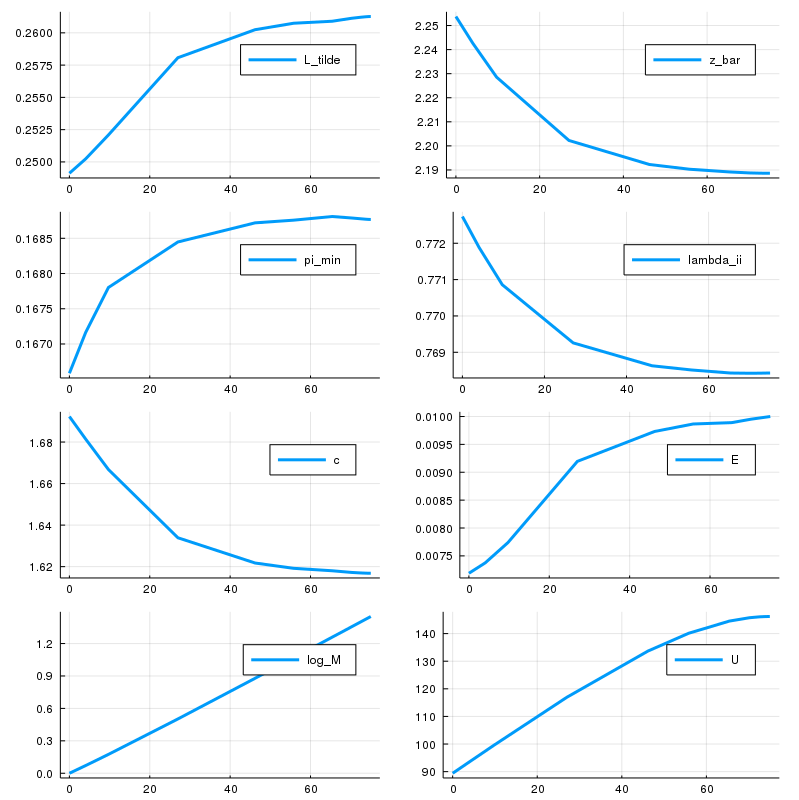

In [533]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_min, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, layout=(4,2), size = (800, 800))

# Welfare analysis

### `log_M(t)`

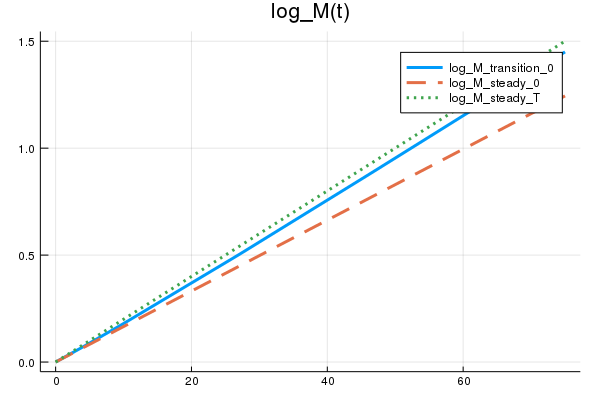

In [534]:
# define log_M with steady state g
log_M_steady_0(t) = stationary_sol_0.g * t
log_M_steady_T(t) = stationary_sol.g * t

# generate the plot!
plot(solved.t, 
    [solved.log_M, log_M_steady_0, log_M_steady_T], 
    label = ["log_M_transition_0", "log_M_steady_0", "log_M_steady_T"] ,
    title = "log_M(t)", linestyle = :auto, lw = 3)

### `Ω(t)`

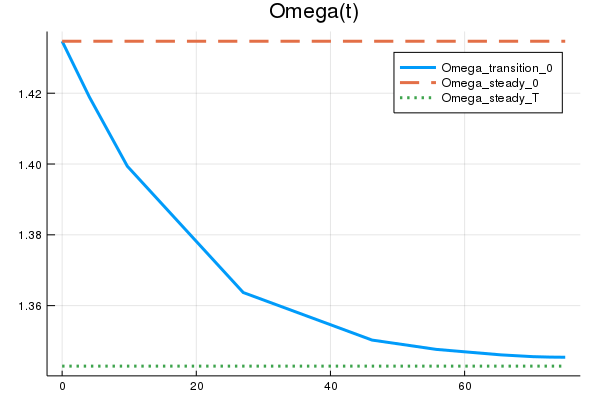

In [535]:
# define Ω function (constant)
Ω_steady_0(t) = stationary_sol_0.Ω
Ω_steady_T(t) = stationary_sol.Ω

# generate the plot!
plot(solved.t, 
    [solved.Ω, Ω_steady_0, Ω_steady_T], 
    label = ["Omega_transition_0", "Omega_steady_0", "Omega_steady_T"] ,
    title = "Omega(t)", linestyle = :auto, lw = 3)

### `c(t)`

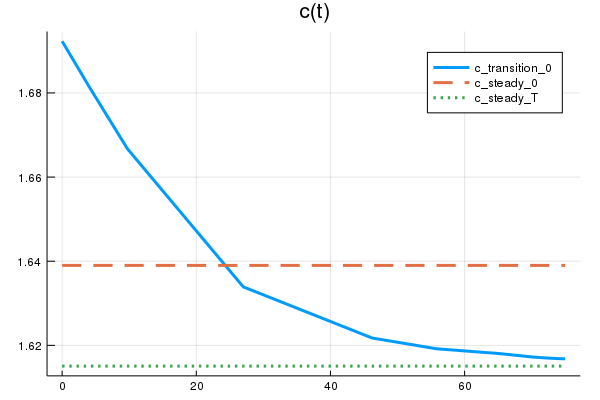

In [536]:
# define c function (constant)
c_steady_0(t) = stationary_sol_0.c
c_steady_T(t) = stationary_sol.c

# generate the plot!
plot(solved.t, 
    [solved.c, c_steady_0, c_steady_T], 
    label = ["c_transition_0", "c_steady_0", "c_steady_T"] ,
    title = "c(t)", linestyle = :auto, lw = 3)

### `U(t)`

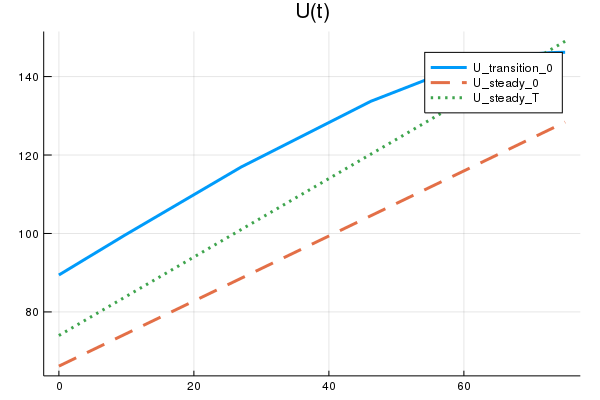

In [537]:
# generate the plot!
plot(solved.t, 
    [solved.U, stationary_sol_0.U_bar, stationary_sol.U_bar], 
    label = ["U_transition_0", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

## Consumption equivalent for search threshold (`M(0)`)
See computational appendix for details.

### `M(0)` by two steady states (autarky and steady state at `T`)

In [29]:
T = solved.t[end]
consumption_equivalent(solved.U[end], stationary_sol_0.U_bar(T), parameters)

1.795854619499635

### `M(0)` by autarky and transition from `t=0`

In [30]:
T = solved.t[end]
consumption_equivalent(solved.U[1], stationary_sol_0.U_bar(T), parameters)

0.5968819496009605

But if we include the transition path, this falls a lot. Like down to 13 percent gain. 

### Continuation Approach

The cell below takes a while to run, but is a relatively robust way to get the solution. 

In [42]:
#= using DFOLS
result = solve_continuation(d_0, # d_0 value
                            d_T, # d_T value
                            step = 0.05, # default is 0.005 
                            params = parameter_defaults(), 
                            settings = settings_defaults(),
                            solver = solve_full_model_dfols)
=#

((z_max = 5, z = [0.0, 0.000250627, 0.000501253, 0.00075188, 0.00100251, 0.00125313, 0.00150376, 0.00175439, 0.00200501, 0.00225564  …  4.63636, 4.67677, 4.71717, 4.75758, 4.79798, 4.83838, 4.87879, 4.91919, 4.9596, 5.0], Δ_E = 1.0e-6, ode_solve_algorithm = Sundials.CVODE_BDF{:Newton,:Dense}(0, 0, 0, 0, false, 10, 5, 7, 3, 10), T = 40.0, t = 0.0:4.444444444444445:40.0, g = [0.0306157, 0.0406157, 0.0506157, 0.0606157, 0.0706157, 0.0806157, 0.0906157, 0.100616, 0.110616, 0.120616], E_node_count = 15, entry_residuals_nodes_count = 15, transition_x0 = [0.0111869, -0.000579962, 0.00197859, 0.000894262, 0.000166219, 0.000459029, -0.000126457, 0.00074618, 0.00150354, -0.000968768, -3.79492e-5, -0.000528005, 1.12952e-6, -8.47501e-7], fifty_node_iv = [-1.00157, -0.848157, -0.821211, -0.821211, -0.821211, -0.748497, -0.633587, -0.527711, -0.498239, -0.498239  …  -0.0713765, -0.0343871, -0.0334064, -0.0334064, -0.029373, -0.029373, -0.029373, -0.029373, -0.029373, -0.029373], continuation_x0 = [0

In [32]:
stationary_sol.U_bar(90)/stationary_sol.U_bar(89)

1.0058310218043576

In [33]:
test_colve

75.0

In [34]:
T-1

74.0

In [35]:
T = solved.t[end]

75.0